In [1]:
import Power_Laws_Generator as plg
import seaborn as sns
import numpy as np
import pandas as pd
import latexify
from sympy.functions.special.gamma_functions import gamma
import time
import matplotlib.pyplot as plt

%matplotlib inline

## Formula display for PDFs

In [2]:
identifiers = {
    'dslope_power_pdf':'p',
    'power_pdf':'p',
    'damped_power_pdf':'p',
}

@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def power_pdf(x, alpha=1.5, xmin=1):
    fx = ((alpha - 1) / xmin)*(x/xmin)**(-alpha)
    return fx

power_pdf

In [3]:
@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def damped_power_pdf(x, xmin=1, alpha=1.5, xc=100):
    C1 = (xc ** (alpha - 1)) / gamma(1-alpha, xmin/xc)
    fx = C1 * np.exp(-x/xc) * x**(-alpha)

    return fx

damped_power_pdf

In [4]:
@latexify.function(reduce_assignments=True, use_math_symbols=True, identifiers=identifiers)
def dslope_power_pdf(x, alpha=4, beta=1.5, xmin=1, xc=100, rho=0.5):
    pob1_part = rho * ((alpha - 1) / xmin) * (x/xmin)**(-alpha)
    pob2_part = (1 - rho) * ((xc ** (beta - 1)) / gamma(1-beta, xmin/xc)) * ((x/xmin)**(-beta)) * np.exp(-x/xc)
    px = pob1_part + pob2_part
    return px

dslope_power_pdf

## Synthetic Data Analysis

In [72]:
sns.set_style('dark')
n_samples = 10000
alpha1 = 4
alpha2 = 2
x_c = 100
x_min=1
top_level = 1
beta = 0.5
n = 1000
n_bins = 30
bootstrap = 100

### Pure Power Law Samplework

In [73]:
# Data Generation
print('Generating Samples...')
x = plg.analytic_power(n_samples, alpha=alpha2, x_min=x_min)
print('Samples Done!')

Generating Samples...
Samples Done!


In [74]:
alpha_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    alpha_pred = np.append(alpha_pred, plg.power_law_max_likelihood(xb))
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {round(1000*(cp2-cp1)/bootstrap, 3)}ms')

# Alpha
alpha_std_bootstrap = plg.bootstrap_std(alpha_pred, bootstrap)
alpha_pred_bootstrap = np.sum(alpha_pred) / bootstrap
x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap = plg.power_pdf(x_estimated, alpha=alpha_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 0.247ms


In [75]:
alpha_pred = plg.power_law_max_likelihood(x)
hess = plg.power_hessian(x, alpha_pred)
print(f'Hessian Matrix:\n{hess}')
alpha_std = np.sqrt(1/hess)
px = plg.power_pdf(x_estimated, alpha=alpha_pred, x_min=x_min)

Hessian Matrix:
9668.080379482988


In [76]:
errors_non_bootstrap = np.array([plg.power_pdf(x_estimated, alpha=alpha_pred + (-1)**(i//1) * alpha_std, x_min=x_min) for i in range(2)])
errors_non_bootstrap = np.array([np.max(errors_non_bootstrap, axis=0), np.min(errors_non_bootstrap, axis=0)])

errors_bootstrap = np.array([plg.power_pdf(x_estimated, alpha=alpha_pred_bootstrap + (-1)**(i//1) * alpha_std_bootstrap, x_min=x_min) for i in range(2)])
errors_bootstrap = np.array([np.max(errors_bootstrap, axis=0), np.min(errors_bootstrap, axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 39329.7267	Bayesian Information Criteria: 39336.9366
Non-Bootstrapped Samples:
	Slope Predicted: 2.0170208904534297 +- 0.010170208904534296

Bootstrapped Samples:
	Slope Predicted: 2.016687982702877 +- 0.009673700866295286


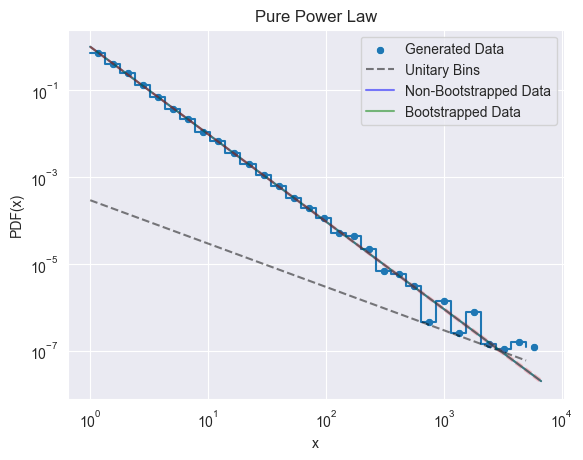

In [77]:
akaike = plg.akaike_information(x, plg.power_law_likelihood, [alpha_pred], x_min=x_min)
bayes = plg.bayesian_information(x, plg.power_law_likelihood, [alpha_pred], x_min=x_min)

print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')
print(f'Non-Bootstrapped Samples:\n\tSlope Predicted: {alpha_pred} +- {alpha_std}')
print(f'\nBootstrapped Samples:\n\tSlope Predicted: {alpha_pred_bootstrap} +- {alpha_std_bootstrap}')

plg.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Pure Power Law')

### Power Law with Cutoff Samplework

In [78]:
# Data Generation
print('Generating Samples...')
x = plg.accept_reject_damped(n_samples, alpha=alpha2, x_c=x_c, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 10000 in 3 iterations with 2320.19% efficiency
Samples Done!


In [79]:
alpha0, x_c0 = alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1)

alpha_pred = np.array([])
x_c_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    result = plg.minimize_by_scipy(xb, plg.cutoff_law_likelihood, (alpha0, x_c0))
    alpha_pred = np.append(alpha_pred, result.x[0])
    x_c_pred = np.append(x_c_pred, result.x[1])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {round(1000*(cp2-cp1)/bootstrap, 3)}ms')
# Alpha
alpha_std_bootstrap = plg.bootstrap_std(alpha_pred, bootstrap)
alpha_pred_bootstrap = np.sum(alpha_pred)/bootstrap
# X_c
x_c_std_bootstrap = plg.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap

x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap = plg.damped_power_pdf(x_estimated, alpha=alpha_pred_bootstrap, x_c=x_c_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 68.94ms


In [80]:
# Maximum Likelihood Estimation
result = plg.minimize_by_scipy(x, plg.cutoff_law_likelihood, (alpha0, x_c0))
alpha_pred, x_c_pred = result.x[0], result.x[1]
hess = plg.damped_power_hessian(x, alpha_pred, x_c_pred)
print(f'Hessian Matrix:\n{hess}')
alpha_std, x_c_std = np.diagonal(np.sqrt(np.linalg.inv(hess)))
px = plg.damped_power_pdf(x_estimated, alpha=alpha_pred, x_c=x_c_pred, x_min=x_min)

Hessian Matrix:
[[-2.73413767e+05  1.08937518e+03]
 [ 9.12249320e+02 -9.66404235e-02]]


In [81]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(4):
    alpha2test = max(1, alpha_pred + (-1)**(i//1)*alpha_std)
    xc2test = max(0, x_c_pred + (-1)**(i//2)*x_c_std)
    errors_non_bootstrap.append(plg.damped_power_pdf(x_estimated, alpha=alpha2test, x_c=xc2test, x_min=x_min))

    alpha2test_b = max(1, alpha_pred_bootstrap + (-1)**(i//1)*alpha_std_bootstrap)
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//2)*x_c_std_bootstrap)
    errors_bootstrap.append(plg.damped_power_pdf(x_estimated, alpha=alpha2test_b, x_c=xc2test_b, x_min=x_min))

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 35390.0672	Bayesian Information Criteria: 35404.4867
Non-Bootstrapped Samples:
	Slope Predicted: 2.028367702255384 +- 0.00031607168117212664
	Damping Factor Predicted: 106.69350145386629 +- 0.5316384261392767

Bootstrapped Samples:
	Slope Predicted: 2.0253324636616568 +- 0.014649703296251341
	Damping Factor Predicted: 104.22515476935007 +- 13.685936643183956


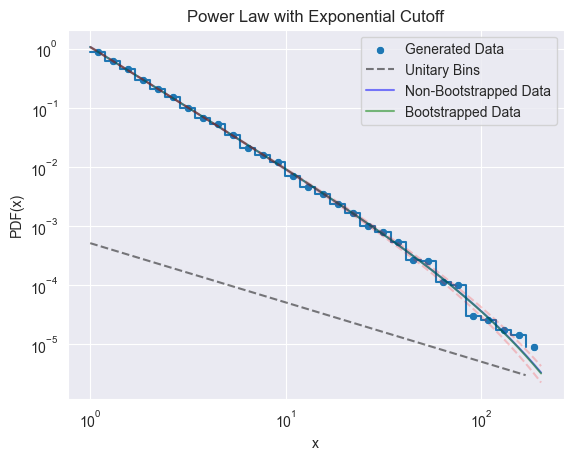

In [82]:
akaike = plg.akaike_information(x, plg.cutoff_law_likelihood, (alpha_pred, x_c_pred), x_min=x_min)
bayes = plg.bayesian_information(x, plg.cutoff_law_likelihood, (alpha_pred, x_c_pred), x_min=x_min)

print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')
print(f'Non-Bootstrapped Samples:\n\tSlope Predicted: {alpha_pred} +- {alpha_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}')
print(f'\nBootstrapped Samples:\n\tSlope Predicted: {alpha_pred_bootstrap} +- {alpha_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}')

plg.plot_data(x, n_bins, x_estimated, px_bootstrap, px, errors, title='Power Law with Exponential Cutoff')

### Double Power Law with Cutoff Samplework

In [58]:
# Data Generation
print('Generating Samples...')
x = plg.double_potential_generation(n_samples, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 4922 in 3 iterations with 2158.77% efficiency
Samples Done!


In [59]:
alpha1_0, alpha2_0, x_c0 = alpha1 + np.random.uniform(-1, 1, 1), alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1)

alpha1_pred = np.array([])
alpha2_pred = np.array([])
x_c_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    result = plg.minimize_by_scipy(xb, plg.dslope_law_likelihood, (alpha1_0, alpha2_0, x_c0))
    alpha1_pred = np.append(alpha1_pred, result.x[0])
    alpha2_pred = np.append(alpha2_pred, result.x[1])
    x_c_pred = np.append(x_c_pred, result.x[2])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {1000 * round((cp2-cp1)/bootstrap, 3)}ms')

# Alpha1
alpha1_std_bootstrap = plg.bootstrap_std(alpha1_pred, bootstrap)
alpha1_pred_bootstrap = np.sum(alpha1_pred)/bootstrap
# Alpha2
alpha2_std_bootstrap = plg.bootstrap_std(alpha2_pred, bootstrap)
alpha2_pred_bootstrap = np.sum(alpha2_pred)/bootstrap
# X_c
x_c_std_bootstrap = plg.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap

x_estimated = np.linspace(min(x), max(x), len(x))
px_bootstrap, tau_b = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred_bootstrap, alpha2=alpha2_pred_bootstrap, x_c=x_c_pred_bootstrap, beta=beta, x_min=x_min)

Time ellapsed per boostrapped sample: 316.0ms


In [60]:
# Maximum Likelihood Estimation
result = plg.minimize_by_scipy(x, plg.dslope_law_likelihood, (alpha1_0, alpha2_0, x_c0))
alpha1_pred, alpha2_pred, x_c_pred = result.x[0], result.x[1], result.x[2]
hess = plg.dslope_power_hessian(x, alpha1_pred, alpha2_pred, x_c_pred)
print(f'Hessian Matrix:\n{hess}')
alpha1_std, alpha2_std, x_c_std = np.diagonal(np.sqrt(abs(np.linalg.inv(hess))))
px, tau = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred, alpha2=alpha2_pred, x_c=x_c_pred, beta=beta, x_min=x_min)

Hessian Matrix:
[[ 5.05386633e+02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -9.96944109e+04  7.11532330e+02]
 [ 0.00000000e+00  5.74032318e+02 -1.58865236e-01]]


In [61]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(8):
    alpha12test = max(1.000001, alpha1_pred + (-1)**(i//1)*alpha1_std)
    alpha22test = min(alpha12test, max(1.000001, alpha2_pred + (-1)**(i//2)*alpha2_std))
    xc2test = max(0, x_c_pred + (-1)**(i//4)*x_c_std)
    errors_non_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test, alpha2=alpha22test, x_c=xc2test, beta=beta, x_min=x_min)[0])

    alpha12test_b = max(1.000001, alpha1_pred_bootstrap + (-1)**(i//1)*alpha1_std_bootstrap)
    alpha22test_b = min(alpha12test_b, max(1.000001, alpha2_pred_bootstrap + (-1)**(i//2)*alpha2_std_bootstrap))
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//4)*x_c_std_bootstrap)
    # print(alpha12test_b, alpha22test_b, xc2test_b)
    errors_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test_b, alpha2=alpha22test_b, x_c=xc2test_b, beta=beta, x_min=x_min)[0])

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 22202.6761	Bayesian Information Criteria: 22224.3047
Non-Bootstrapped Samples:
	Slope 1 Predicted: 4.146755003379953 +- 0.044482391143297384
	Slope 2 Predicted: 1.9608982727249402 +- 0.0006361166423900237
	Damping Factor Predicted: 69.3930659234799 +- 0.5039155114272011
	Crossing Point Predicted: 129.89559998410337

Bootstrapped Samples:
	Slope 1 Predicted: 4.157789796844908 +- 0.08226924212490243
	Slope 2 Predicted: 1.952829946306102 +- 0.030503620833372862
	Damping Factor Predicted: 69.2067400683966 +- 12.284932156164793
	Crossing Point Predicted: 137.98157783752762


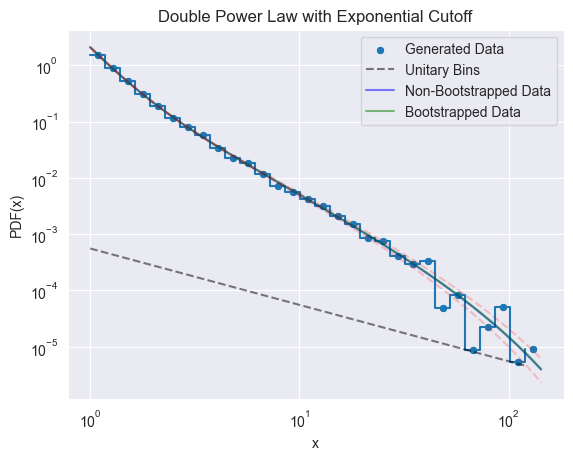

In [66]:
akaike = plg.akaike_information(x, plg.dslope_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred), x_min=x_min)
bayes = plg.bayesian_information(x, plg.dslope_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred), x_min=x_min)
print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')

print(f'Non-Bootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred} +- {alpha1_std}\n\tSlope 2 Predicted: {alpha2_pred} +- {alpha2_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}\n\tCrossing Point Predicted: {tau}')
print(f'\nBootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred_bootstrap} +- {alpha1_std_bootstrap}\n\tSlope 2 Predicted: {alpha2_pred_bootstrap} +- {alpha2_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}\n\tCrossing Point Predicted: {tau_b}')

plg.plot_data(x, 30, x_estimated, px_bootstrap, px, errors, title='Double Power Law with Exponential Cutoff')

### Double Power Law with Cutoff and Unknown Population Distribution Samplework

In [67]:
# Data Generation
print('Generating Samples...')
x = plg.double_potential_generation(n_samples, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min)
print('Samples Done!')

Generating Samples...
Generated 4905 in 3 iterations with 2464.82% efficiency
Samples Done!


In [68]:
alpha1_0, alpha2_0, x_c0, beta0 = alpha1 + np.random.uniform(-1, 1, 1), alpha2 + np.random.uniform(-1, 1, 1), x_c + np.random.uniform(-10, 10, 1), beta + np.random.uniform(-0.3, 0.3, 1)

alpha1_pred = np.array([])
alpha2_pred = np.array([])
x_c_pred = np.array([])
beta_pred = np.array([])

cp1 = time.perf_counter()
for _ in range(bootstrap):
    xb = plg.bootstrap_sample(x)
    result = plg.minimize_by_scipy(xb, plg.dslope_noprob_law_likelihood, (alpha1_0, alpha2_0, x_c0, beta0))
    alpha1_pred = np.append(alpha1_pred, result.x[0])
    alpha2_pred = np.append(alpha2_pred,result.x[1])
    x_c_pred = np.append(x_c_pred,result.x[2])
    beta_pred = np.append(beta_pred,result.x[3])
cp2 = time.perf_counter()
print(f'Time ellapsed per boostrapped sample: {1000 * round((cp2-cp1)/bootstrap, 3)}ms')

# Alpha1
alpha1_std_bootstrap = plg.bootstrap_std(alpha1_pred, bootstrap)
alpha1_pred_bootstrap = np.sum(alpha1_pred)/bootstrap
# Alpha2
alpha2_std_bootstrap = plg.bootstrap_std(alpha2_pred, bootstrap)
alpha2_pred_bootstrap = np.sum(alpha2_pred)/bootstrap
# X_c
x_c_std_bootstrap = plg.bootstrap_std(x_c_pred, bootstrap)
x_c_pred_bootstrap = np.sum(x_c_pred)/bootstrap
# Beta
beta_std_bootstrap = plg.bootstrap_std(beta_pred, bootstrap)
beta_pred_bootstrap = np.sum(beta_pred)/bootstrap

x_estimated = np.linspace(min(x), max(x), n_samples)
px_bootstrap, tau_b = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred_bootstrap, alpha2=alpha2_pred_bootstrap, x_c=x_c_pred_bootstrap, beta=beta_pred_bootstrap, x_min=x_min)

Time ellapsed per boostrapped sample: 536.0ms


In [69]:
# Maximum Likelihood Estimation
result = plg.minimize_by_scipy(x, plg.dslope_noprob_law_likelihood, (alpha1_0, alpha2_0, x_c0, beta0))
alpha1_pred, alpha2_pred, x_c_pred, beta_pred = result.x[0], result.x[1], result.x[2], result.x[3]
hess = plg.dslope_power_no_prob_hessian(x, alpha1_pred, alpha2_pred, x_c_pred, beta_pred)
print(f'Hessian Matrix:\n{hess}')
alpha1_std, alpha2_std, x_c_std, beta_std = np.diagonal(np.sqrt(np.linalg.inv(hess)))
px, tau = plg.dslope_power_pdf(x_estimated, alpha1=alpha1_pred, alpha2=alpha2_pred, x_c=x_c_pred, beta=beta_pred, x_min=x_min)

Hessian Matrix:
[[ 4.65306427e+02  0.00000000e+00  0.00000000e+00 -1.18144616e-05]
 [ 0.00000000e+00 -1.41907937e+05  6.07632628e+02 -9.64159044e+04]
 [ 0.00000000e+00  5.11285133e+02 -5.50858951e-02  6.42967224e+00]
 [-5.62614274e-06 -5.05018664e+04  3.36781002e+00  1.00000000e+00]]


In [70]:
errors_non_bootstrap = []
errors_bootstrap = []
for i in range(16):
    alpha12test = max(1, alpha1_pred + (-1)**(i//1)*alpha1_std)
    alpha22test = min(alpha12test, max(1, alpha2_pred + (-1)**(i//2)*alpha2_std))
    xc2test = max(0, x_c_pred + (-1)**(i//4)*x_c_std)
    beta2test = min(1, max(0, beta_pred + (-1)**(i//8)*beta_std))
    errors_non_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test, alpha2=alpha22test, x_c=xc2test, beta=beta2test, x_min=x_min)[0])

    alpha12test_b = max(1, alpha1_pred_bootstrap + (-1)**(i//1)*alpha1_std_bootstrap)
    alpha22test_b = min(alpha12test_b, max(1, alpha2_pred_bootstrap + (-1)**(i//2)*alpha2_std_bootstrap))
    xc2test_b = max(0, x_c_pred_bootstrap + (-1)**(i//4)*x_c_std_bootstrap)
    beta2test_b = min(1, max(0, beta_pred_bootstrap + (-1)**(i//8)*beta_std_bootstrap))
    errors_bootstrap.append(plg.dslope_power_pdf(x_estimated, alpha1=alpha12test_b, alpha2=alpha22test_b, x_c=xc2test_b, beta=beta2test_b, x_min=x_min)[0])

errors_non_bootstrap = np.array([np.max(np.array(errors_non_bootstrap), axis=0), np.min(np.array(errors_non_bootstrap), axis=0)])
errors_bootstrap = np.array([np.max(np.array(errors_bootstrap), axis=0), np.min(np.array(errors_bootstrap), axis=0)])

errors = np.array([errors_non_bootstrap, errors_bootstrap])

Akaike Information Criteria: 21757.1631	Bayesian Information Criteria: 21786.0005
Non-Bootstrapped Samples:
	Slope 1 Predicted: 4.199107831897897 +- 0.04635861730958794
	Slope 2 Predicted: 2.0542987862643103 +- 0.000484893331029571
	Damping Factor Predicted: 101.66521473548642 +- 7.2620741529122235
	Probability Predicted: 0.47620813504247206 +- 0.05727230696247854
	Crossing Point Predicted: 128.08690206945906

Bootstrapped Samples:
	Slope 1 Predicted: 4.213431022929669 +- 0.29428223040965645
	Slope 2 Predicted: 2.03181581250222 +- 0.10336210111839741
	Damping Factor Predicted: 104.29521952358779 +- 34.44357925644122
	Probability Predicted: 0.48706994485817906 +- 0.06878873609195175
	Crossing Point Predicted: 159.50528613608222


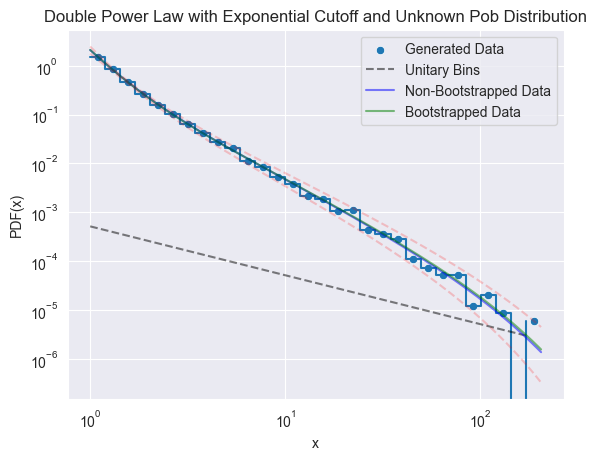

In [71]:
akaike = plg.akaike_information(x, plg.dslope_noprob_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred, beta_pred), x_min=x_min)
bayes = plg.bayesian_information(x, plg.dslope_noprob_law_likelihood, (alpha1_pred, alpha2_pred, x_c_pred, beta_pred), x_min=x_min)

print(f'Akaike Information Criteria: {round(akaike, 4)}\tBayesian Information Criteria: {round(bayes, 4)}')

print(f'Non-Bootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred} +- {alpha1_std}\n\tSlope 2 Predicted: {alpha2_pred} +- {alpha2_std}\n\tDamping Factor Predicted: {x_c_pred} +- {x_c_std}\n\tProbability Predicted: {beta_pred} +- {beta_std}\n\tCrossing Point Predicted: {tau}')
print(f'\nBootstrapped Samples:\n\tSlope 1 Predicted: {alpha1_pred_bootstrap} +- {alpha1_std_bootstrap}\n\tSlope 2 Predicted: {alpha2_pred_bootstrap} +- {alpha2_std_bootstrap}\n\tDamping Factor Predicted: {x_c_pred_bootstrap} +- {x_c_std_bootstrap}\n\tProbability Predicted: {beta_pred_bootstrap} +- {beta_std_bootstrap}\n\tCrossing Point Predicted: {tau_b}')
        
plg.plot_data(x, 30, x_estimated, px_bootstrap, px, errors, title='Double Power Law with Exponential Cutoff and Unknown Pob Distribution')

## Real Data Analysis

### Data 1

In [26]:
data1 = pd.read_csv('data/c1/simBondPercAllp0.40hL256_lat_c1.dat', sep='\t', header=None)
x1 = data1[data1[0] >= 8][0].to_numpy() 
x1 = x1 / min(x1)
len(x1)

205493

Time ellapsed to Compute the Hessian: 0.004ms
Akaike Information Criteria: 598723.9883	Bayesian Information Criteria: 598734.2214

Non-Bootstrapped Samples:
	Slope Predicted: 2.3375514541512645 +- 0.0029506111662227132

Bootstrapped Samples:
	Slope Predicted: 2.337571341921028 +- 0.0024828896487376455


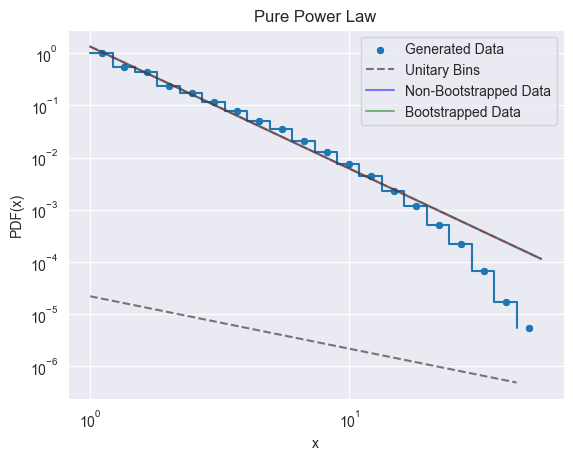

2.3375514541512645

In [27]:
plg.generate_power_law_sample(x=x1, alpha=2, x_min=1, show_data=True, n_bins=20, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 2376.823ms
Akaike Information Criteria: 594388.3431	Bayesian Information Criteria: 594408.8094

Non-Bootstrapped Samples:
	Slope Predicted: 2.0242223253444567 +- 0.00019488609408367425
	Damping Factor Predicted: 16.92120569871551 +- 0.01626710041239359

Bootstrapped Samples:
	Slope Predicted: 2.0301914014455473 +- 0.0522895555031776
	Damping Factor Predicted: 16.81506228906569 +- 1.7230568530571015


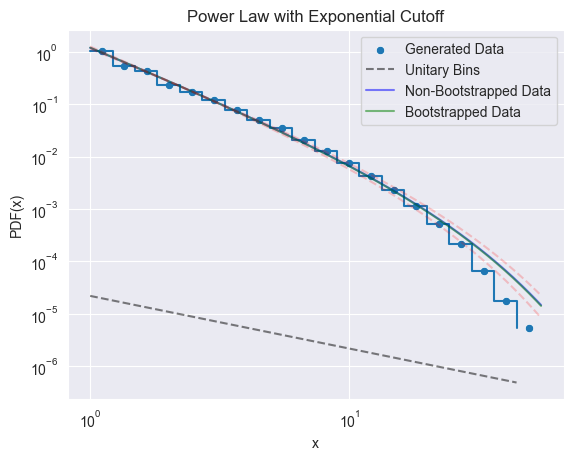

(2.0242223253444567, 16.92120569871551)

In [54]:
plg.generate_cutoff_law_sample(x=x1, alpha=2.2, x_c=16.9, x_min=1, show_data=True, n_bins=20, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 2511.045ms
Akaike Information Criteria: 589629.257	Bayesian Information Criteria: 589659.9564

Non-Bootstrapped Samples:
	Slope 1 Predicted: 3.5982452522072697 +- 0.008141105587596805
	Slope 2 Predicted: 0.6286928895472821 +- 0.009094068095221525
	Damping Factor Predicted: 4.716353264637235 +- 0.03573197341924319
	Crossing Point Predicted: 1.6823722918857127

Bootstrapped Samples:
	Slope 1 Predicted: 3.5996658517116225 +- 0.01550592229381972
	Slope 2 Predicted: 0.627494462291935 +- 0.015167714937511867
	Damping Factor Predicted: 4.7169122806956505 +- 0.06758799774244618
	Crossing Point Predicted: 1.6802894982161283


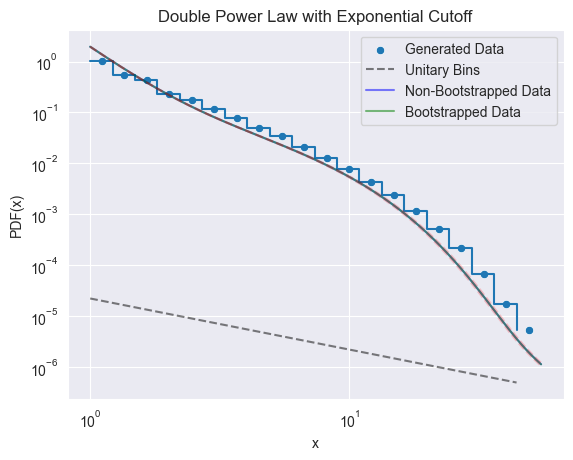

(3.5982452522072697, 0.6286928895472821, 4.716353264637235)

In [56]:
plg.generate_dslope_law_sample(x=x1, alpha1=3.6, alpha2=0.6, x_c=5, beta=0.7, x_min=x_min, show_data=True, n_bins=20, bootstrap=100)

Time ellapsed to Compute the Hessian: 2145.726ms
Akaike Information Criteria: 590675.0039	Bayesian Information Criteria: 590715.9364

Non-Bootstrapped Samples:
	Slope 1 Predicted: 6.0 +- 0.03670903013905666
	Slope 2 Predicted: 2.0 +- 0.0001982666173579766
	Damping Factor Predicted: 21.12393326922719 +- 0.14541220133383506
	Probability Predicted: 0.11145259349687486 +- 0.007687938401143857
	Crossing Point Predicted: 4.103715235347702

Bootstrapped Samples:
	Slope 1 Predicted: 4.000004819919768 +- 2.828420308350285
	Slope 2 Predicted: 1.488786577947296 +- 0.3181408937428621
	Damping Factor Predicted: 3.275233203556765 +- 4.629279292807068
	Probability Predicted: 0.4129862284982494 +- 0.25545341494611756
	Crossing Point Predicted: 2.3658884703843546


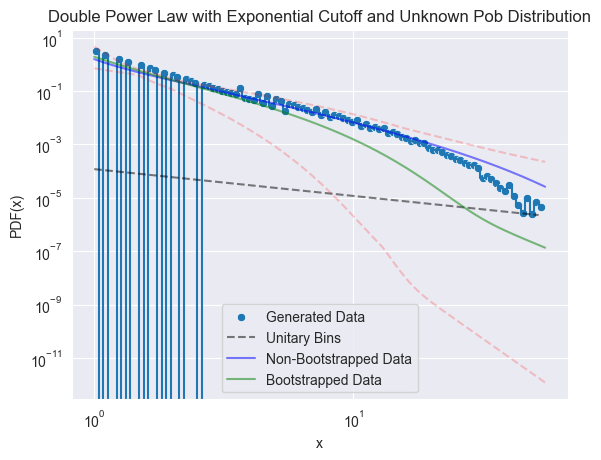

(6.0, 2.0, 21.12393326922719, 0.11145259349687486)

In [31]:
plg.generate_dslope_noprob_law_sample(x=x1, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min, show_data=True, n_bins=20, bootstrap=100)

### Data 2

In [32]:
data2 = pd.read_csv('data/c2/13_23_bzr_events_c2.dat', sep='\s', header=None)
x2 = data2[1].to_numpy()
len(x2)

5013

Time ellapsed to Compute the Hessian: 0.002ms
Akaike Information Criteria: 50530.631	Bayesian Information Criteria: 50537.15

Non-Bootstrapped Samples:
	Slope Predicted: 1.3383016081985804 +- 0.004778099727478932

Bootstrapped Samples:
	Slope Predicted: 1.338452431318476 +- 0.0034684432438318205


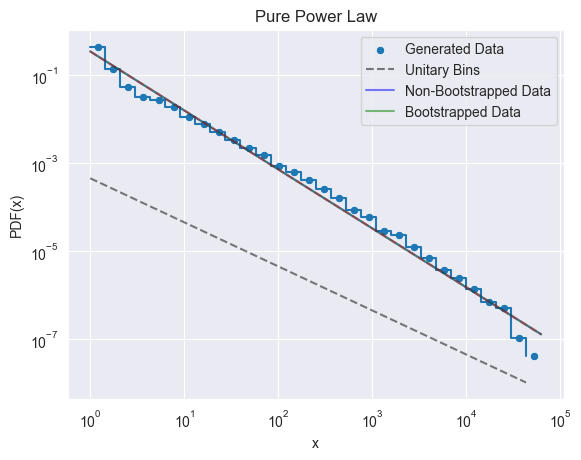

1.3383016081985804

In [33]:
plg.generate_power_law_sample(x=x2, alpha=alpha2, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 2754.477ms
Akaike Information Criteria: 50179.9491	Bayesian Information Criteria: 50192.9863

Non-Bootstrapped Samples:
	Slope Predicted: 1.2638297217774117 +- 0.000899339375269158
	Damping Factor Predicted: 27309.717476320173 +- 644.6718139538704

Bootstrapped Samples:
	Slope Predicted: 1.2625439666196734 +- 0.006836370053567673
	Damping Factor Predicted: 26707.95501571458 +- 2601.222307227008


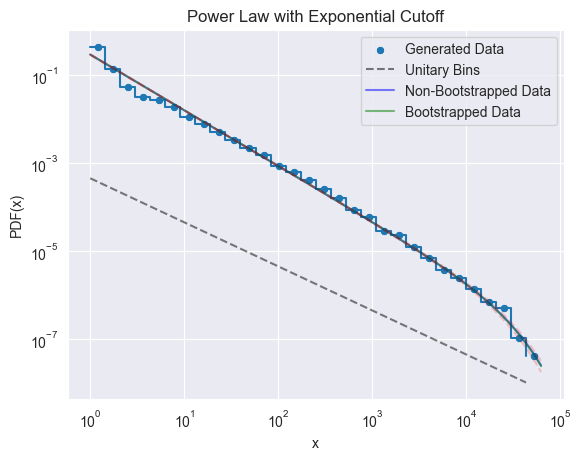

(1.2638297217774117, 27309.717476320173)

In [34]:
plg.generate_cutoff_law_sample(x=x2, alpha=alpha2, x_c=x_c, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 2537.2ms
Akaike Information Criteria: 50767.4079	Bayesian Information Criteria: 50786.9625

Non-Bootstrapped Samples:
	Slope 1 Predicted: 1.2 +- 0.004128184346299102
	Slope 2 Predicted: 1.3518245513767813 +- 0.0009444040331731046
	Damping Factor Predicted: 10080.503263748094 +- 260.4385015659558
	Crossing Point Predicted: 6.259747717542399e-20

Bootstrapped Samples:
	Slope 1 Predicted: 1.7017582756110976 +- 0.039357397968618445
	Slope 2 Predicted: 1.0078809408591143 +- 0.012963722488402713
	Damping Factor Predicted: 10788.039579309941 +- 1166.6522333386442
	Crossing Point Predicted: 54.48518806577252


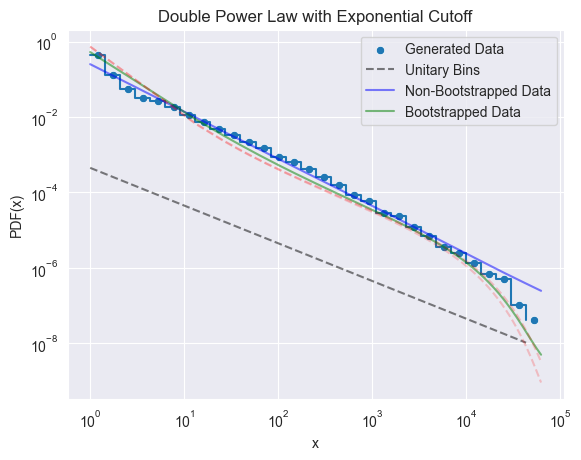

(1.2, 1.3518245513767813, 10080.503263748094)

In [92]:
plg.generate_dslope_law_sample(x=x2, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.7, x_min=x_min, show_data=True, n_bins=30, bootstrap=100)

In [93]:
plg.generate_dslope_noprob_law_sample(x=x2, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 3222.475ms


ZeroDivisionError: division by zero

### Data 3

In [94]:
data3 = pd.read_csv('data/c8/simELFBM-W-a1.50h0.00L256_it50.Seq', sep='\s+', header=None)
x3 = data3[7].to_numpy()
len(x3)

150463

Time ellapsed to Compute the Hessian: 0.005ms
Akaike Information Criteria: 37519.7504	Bayesian Information Criteria: 37529.6718

Non-Bootstrapped Samples:
	Slope Predicted: 4.260865645466187 +- 0.008406554772812286

Bootstrapped Samples:
	Slope Predicted: 4.262102346325827 +- 0.014665269707483733


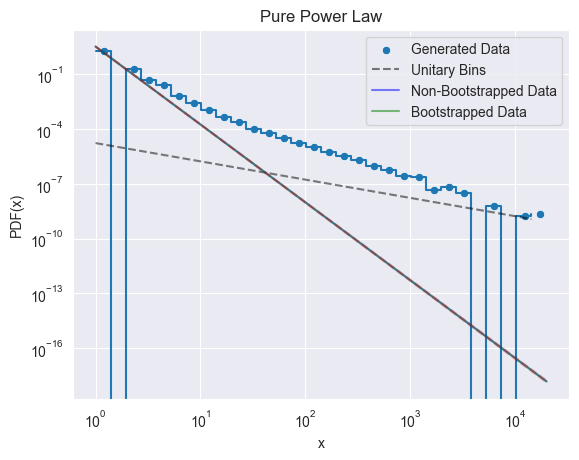

4.260865645466187

In [95]:
plg.generate_power_law_sample(x=x3, alpha=alpha2, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 1896.191ms
Akaike Information Criteria: 37561.661	Bayesian Information Criteria: 37581.5038

Non-Bootstrapped Samples:
	Slope Predicted: 4.260695992604322 +- 4.246958035457695e-07
	Damping Factor Predicted: 11794.659799855155 +- 5.355040005530253

Bootstrapped Samples:
	Slope Predicted: 4.263246523552748 +- 0.05180463184529516
	Damping Factor Predicted: 19324.18837933187 +- 10895.084789361788


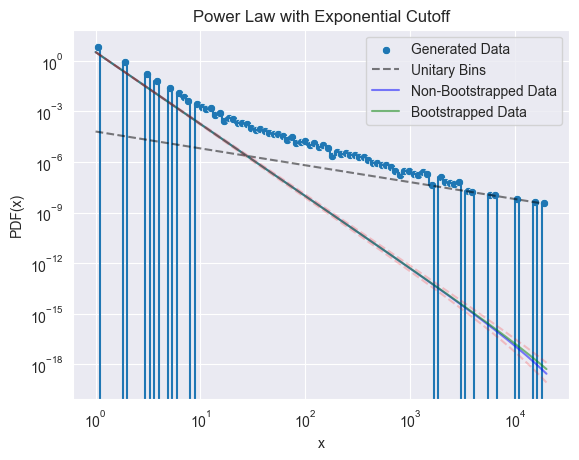

(4.260695992604322, 11794.659799855155)

In [39]:
plg.generate_cutoff_law_sample(x=x3, alpha=alpha2, x_c=x_c, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 1800.686ms
Akaike Information Criteria: -9345.7595	Bayesian Information Criteria: -9315.9952

Non-Bootstrapped Samples:
	Slope 1 Predicted: 6.0 +- 0.016108224298469927
	Slope 2 Predicted: 2.0 +- 3.801253800970426e-05
	Damping Factor Predicted: 1081.9479474224574 +- 2.544123880006009
	Crossing Point Predicted: 49.66881841165318

Bootstrapped Samples:
	Slope 1 Predicted: 5.999945414378955 +- 0.00015741101512984642
	Slope 2 Predicted: 1.9998950410222838 +- 0.00016647579034741324
	Damping Factor Predicted: 894.3163562041252 +- 652.0992367000129
	Crossing Point Predicted: 45.178007941840015


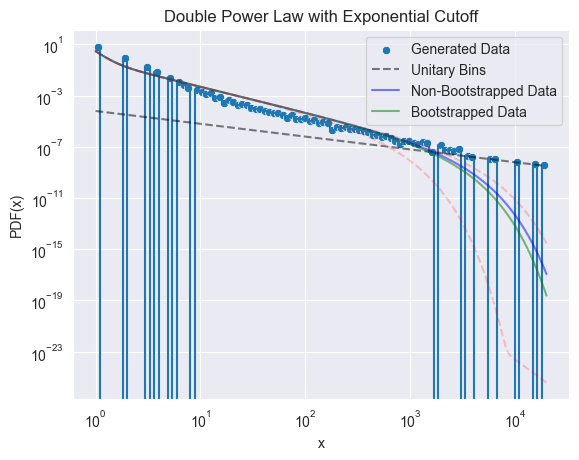

(6.0, 2.0, 1081.9479474224574)

In [40]:
plg.generate_dslope_law_sample(x=x3, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=beta, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

Time ellapsed to Compute the Hessian: 1832.057ms
Akaike Information Criteria: -33891.4511	Bayesian Information Criteria: -33851.7655

Non-Bootstrapped Samples:
	Slope 1 Predicted: 6.0 +- 0.0009409194371966548
	Slope 2 Predicted: 1.9325878631566737 +- 3.360932781483816e-05
	Damping Factor Predicted: 3862.201237256413 +- 38.80638907605383
	Probability Predicted: 0.7764054413519996 +- 0.004674345125322324
	Crossing Point Predicted: 91.03798371165706

Bootstrapped Samples:
	Slope 1 Predicted: 5.997274249924973 +- 0.02197363165120688
	Slope 2 Predicted: 1.9182307740571505 +- 0.019518932120646565
	Damping Factor Predicted: 1970.0864281987133 +- 1399.8554094137105
	Probability Predicted: 0.7845830133564398 +- 0.03780962901370168
	Crossing Point Predicted: 63.6955371247045


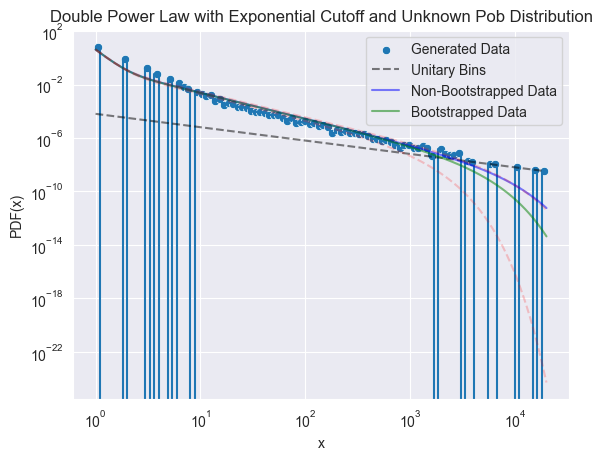

(6.0, 1.9325878631566737, 3862.201237256413, 0.7764054413519996)

In [41]:
plg.generate_dslope_noprob_law_sample(x=x3, alpha1=alpha1, alpha2=alpha2, x_c=x_c, beta=0.8, x_min=x_min, show_data=True, n_bins=30, bootstrap=bootstrap)

In [42]:
min(x3)

1